In [45]:
from utilities import input_tools, boostHistHelpers as hh,common
from wremnants import theory_tools, theory_corrections, plot_tools
import uproot
import matplotlib.pyplot as plt
import hist
import pickle
import lz4.frame
import os
import numpy as np
from wremnants import syst_tools,histselections as sel

In [40]:
%load_ext autoreload
%autoreload 2

In [751]:
def dyturbo_coeff(dyturbof, coeff, obs, make_abs=False, binning=None):
    sigmai = dyturbof[f"wgt_{coeff}_{obs}"].to_hist()
    sigmaul = dyturbof[f"s_{obs}"].to_hist()
    ax = "xaxis"
    if make_abs:
        sigmai = hh.makeAbsHist(sigmai, ax)
        sigmaul = hh.makeAbsHist(sigmaul, ax)
        ax = f"abs{ax}"
    if binning is not None:
        sigmai = hh.rebinHist(sigmai, ax, binning)
        sigmaul = hh.rebinHist(sigmaul, ax, binning)

    return theory_corrections.make_angular_coeff(sigmai, sigmaul)

In [621]:
def plotAllCoeffs(obs, minnlo, nnlops, rebin, label, out):
    if rebin is not None:
        minnlo = hh.rebinHist(minnlo, obs, rebin)
        nnlops = hh.rebinHist(nnlops, obs, rebin)
    
    minnlo_coeffs = theory_tools.moments_to_angular_coeffs(minnlo.project(obs, "helicity"))

    for i in range(8):
        nnlops_coeffs = theory_tools.moments_to_angular_coeffs(nnlops.project(obs, "helicity"))

        fig = plot_tools.makePlotWithRatioToRef(
                [minnlo_coeffs[{"helicity" : complex(i)}], 
                 nnlops_coeffs[{"helicity" : complex(i)}]], 
                ["MiNNLO", 'NNLOPS',], 
                colors=['orange', 'red',], 
                xlabel=label, 
                ylabel=f"A$_{i}$",
                rlabel="x/minnlo",
                rrange=[0.5, 1.5],
                yscale=1.2,
                xlim=None, binwnorm=None, baseline=True)
        name = f"A{i}_{obs}_MiNNLO_NNLOPS"
        plot_tools.save_pdf_and_png(out, name)
        plot_tools.write_index_and_log(out, name)

In [638]:
def plotAllCoeffsDYTurbo(obs, minnlo, dyturbof, rebin, label, out):
    if rebin is not None:
        minnlo = hh.rebinHist(minnlo, obs, rebin)
            
    minnlo_coeffs = theory_tools.moments_to_angular_coeffs(minnlo.project(obs, "helicity"))

    for i in range(8):
        dyturbo = dyturbo_coeff(dyturbof, f"a{i}", obs if obs != "ptVgen" else "qt", binning=minnlo_coeffs.axes[obs].edges)

        fig = plot_tools.makePlotWithRatioToRef(
                [minnlo_coeffs[{"helicity" : complex(i)}], 
                 dyturbo*(-1. if i in [1,4,6] else 1.)], 
                ["MiNNLO", 'DYTurbo',], 
                colors=['orange', 'blue',], 
                xlabel=label, 
                ylabel=f"A$_{i}$",
                rlabel="x/minnlo",
                rrange=[0.5, 1.5],
                yscale=1.2,
                xlim=None, binwnorm=None, baseline=True)
        name = f"A{i}_Wminus_{obs}_MiNNLO_DYTurbo"
        plot_tools.save_pdf_and_png(out, name)
        plot_tools.write_index_and_log(out, name)

In [21]:
with lz4.frame.open("../w_z_gen_dists_nnpdf31.pkl.lz4") as f:
    res = pickle.load(f)

In [22]:
res.keys()

dict_keys(['ZmumuPostVFP', 'ZtautauPostVFP', 'WplusmunuPostVFP', 'WminusmunuPostVFP', 'WplustaunuPostVFP', 'WminustaunuPostVFP', 'meta_info'])

In [779]:
dyturbof_pt = uproot.open("~/wm-13tev-cms-wmass_nnlo_vj_pt_v2.root")
dyturbof_y = uproot.open("~/wm-13tev-cms-wmass_nnlo_vj_y_v2.root")

In [229]:
minnloZh = input_tools.load_and_scale(res, "ZmumuPostVFP", "helicity_moments_scale")[{"muRfact" : 1.j, "muFfact" : 1.j}].project("ptVgen", "y", "massVgen", "helicity")
#minloZh = input_tools.load_and_scale(res, "ZmumuMiNLO", "helicity_moments_scale")[{"muRfact" : 1.j, "muFfact" : 1.j}].project("ptVgen", "absYVgen", "massVgen", "helicity")
#nnlopsZh = input_tools.load_and_scale(res, "ZmumuNNLOPS", "helicity_moments_scale")[{"muRfact" : 1.j, "muFfact" : 1.j}].project("ptVgen", "absYVgen", "massVgen", "helicity")
minnloWh = input_tools.load_and_scale(res, "WminusmunuPostVFP", "helicity_moments_scale")[{"muRfact" : 1.j, "muFfact" : 1.j}].project("ptVgen", "y", "massVgen", "helicity")

In [1223]:
scetlib_sigma4 = input_tools.read_scetlib_hist("/home/k/kelong/work/Generators/TheoryCorrections/SCETlib/Wminus/inclusive_Wm_A4.npz", flip_y_sign=True)
scetlib_sigmaul = input_tools.read_scetlib_hist("/home/k/kelong/work/Generators/TheoryCorrections/SCETlib/Wminus/inclusive_Wm.npz")
scetlib_a4_pt = theory_corrections.make_angular_coeff(scetlib_sigma4.project("pt"), scetlib_sigmaul.project("pt"))

minnloWh = hh.rebinHist(minnloWh, "y", 5)
scetlib_a4_y = theory_corrections.make_angular_coeff(scetlib_sigma4.project("y"), scetlib_sigmaul.project("y"))

In [1224]:
minnlo_coeffs_y = theory_tools.moments_to_angular_coeffs(minnloWh.project("y", "helicity"))

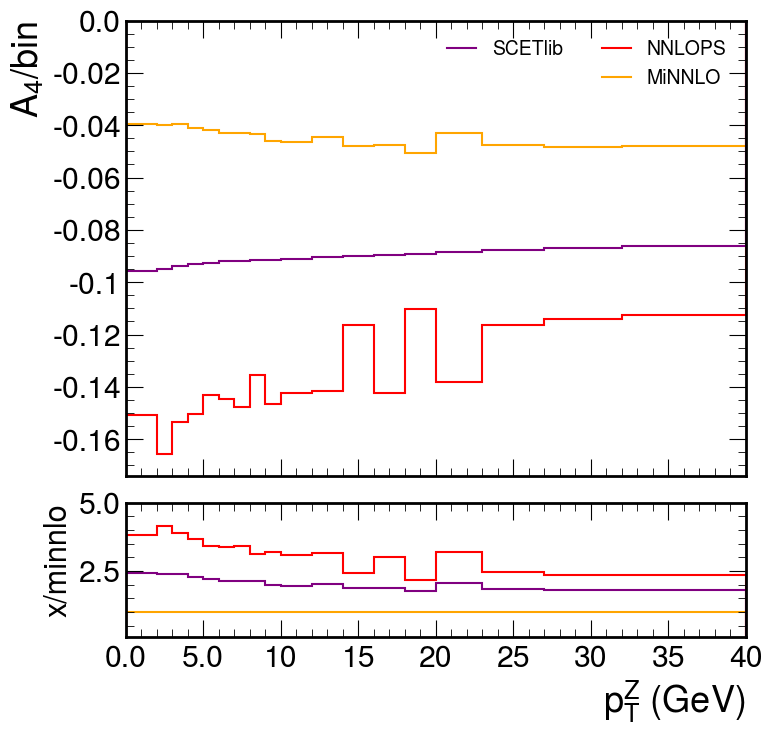

In [1225]:
scetlibhZ_tot = input_tools.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z.npz", charge=0)
scetlibhZ_A4 = input_tools.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/inclusive_Z_pT_A4.npz", nonsing=None, flip_y_sign=True, charge=0)
scetlibhZ_tot, scetlibhZ_A4 = [hh.rebinHist(h, "pt", pt_binning[:-2]) for h in [scetlibhZ_tot, scetlibhZ_A4]]

minnloZ_coeffs_pt = theory_tools.moments_to_angular_coeffs(hh.rebinHist(minnloZh.project("ptVgen", "helicity"), "ptVgen", pt_binning))
nnlopsZ_coeffs_pt = theory_tools.moments_to_angular_coeffs(hh.rebinHist(nnlopsZh.project("ptVgen", "helicity"), "ptVgen", pt_binning))
scetlibZ_a4_coeff = theory_corrections.make_angular_coeff(scetlibhZ_A4.project("pt"), scetlibhZ_tot.project("pt"))

fig = plot_tools.makePlotWithRatioToRef(
            [minnloZ_coeffs_pt[{"helicity" : 4.j}][:40.j], nnlops_coeffs_pt[{"helicity" : 4.j}][:40.j], scetlibZ_a4_coeff], 
            ["MiNNLO", 'NNLOPS', "SCETlib"], 
            colors=['orange', 'red', "purple"], 
            xlabel="p$_{T}^{Z}$ (GeV)", 
            ylabel="A$_{4}$/bin",
            rlabel="x/minnlo",
            rrange=[0.1, 5],
            #ylim=[-0.8,-0.3],
            baseline=True)

out = "/home/k/kelong/www/WMassAnalysis/TheoryComparisons/Z/AngularCoeffs"
name = f"A4_ptVgen_MiNNLO_NNLOPS_SCETlib"
plot_tools.save_pdf_and_png(out, name)
plot_tools.write_index_and_log(out, name)

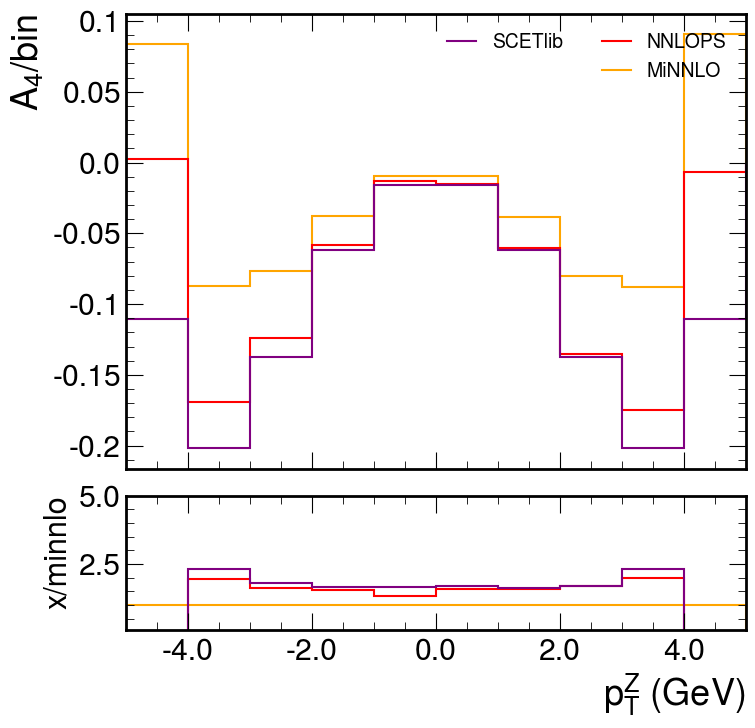

In [804]:
s = hist.tag.Slicer()



minnloZ_coeffs_y = theory_tools.moments_to_angular_coeffs(hh.rebinHist(minnloZh[{"ptVgen" : s[0:40.j:hist.sum]}].project("y", "helicity"), "y", 20))
nnlopsZ_coeffs_y = theory_tools.moments_to_angular_coeffs(hh.rebinHist(nnlopsZh[{"ptVgen" : s[0:40.j:hist.sum]}].project("y", "helicity"), "y", 20))
scetlibZ_y_a4_coeff = theory_corrections.make_angular_coeff(scetlibhZ_A4.project("y"), scetlibhZ_tot.project("y"))


fig = plot_tools.makePlotWithRatioToRef(
            [minnloZ_coeffs_y[{"helicity" : 4.j}], nnlopsZ_coeffs_y[{"helicity" : 4.j}], scetlibZ_y_a4_coeff], 
            ["MiNNLO", 'NNLOPS', "SCETlib"], 
            colors=['orange', 'red', "purple"], 
            xlabel="p$_{T}^{Z}$ (GeV)", 
            ylabel="A$_{4}$/bin",
            rlabel="x/minnlo",
            rrange=[0.1, 5],
            #ylim=[-0.8,-0.3],
            baseline=True)

out = "/home/k/kelong/www/WMassAnalysis/TheoryComparisons/Z/AngularCoeffs"
name = f"A4_y_MiNNLO_NNLOPS_SCETlib"
plot_tools.save_pdf_and_png(out, name)
plot_tools.write_index_and_log(out, name)

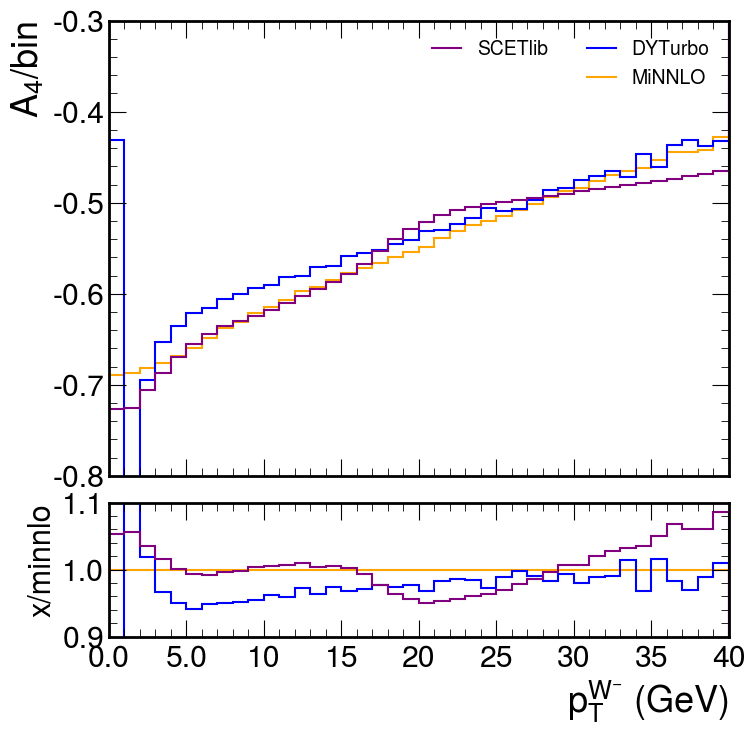

In [775]:
minnlo_coeffs_pt = theory_tools.moments_to_angular_coeffs(minnloh.project("ptVgen", "helicity"))

fig = plot_tools.makePlotWithRatioToRef(
            [minnlo_coeffs_pt[{"helicity" : 4.j}][:40.j], -1*dyturbo_a4_pt[:40.j], scetlib_a4_pt], 
            ["MiNNLO", 'DYTurbo', "SCETlib"], 
            colors=['orange', 'blue', "purple"], 
            xlabel="p$_{T}^{W^{-}}$ (GeV)", 
            ylabel="A$_{4}$/bin",
            rlabel="x/minnlo",
            rrange=[0.9, 1.1],
            ylim=[-0.8,-0.3],
            xlim=None, binwnorm=None, baseline=True)

out = "/home/k/kelong/www/WMassAnalysis/TheoryComparisons/W"
name = f"A4_ptVgen_MiNNLO_DYTurbo_SCETlib"
plot_tools.save_pdf_and_png(out, name)
plot_tools.write_index_and_log(out, name)

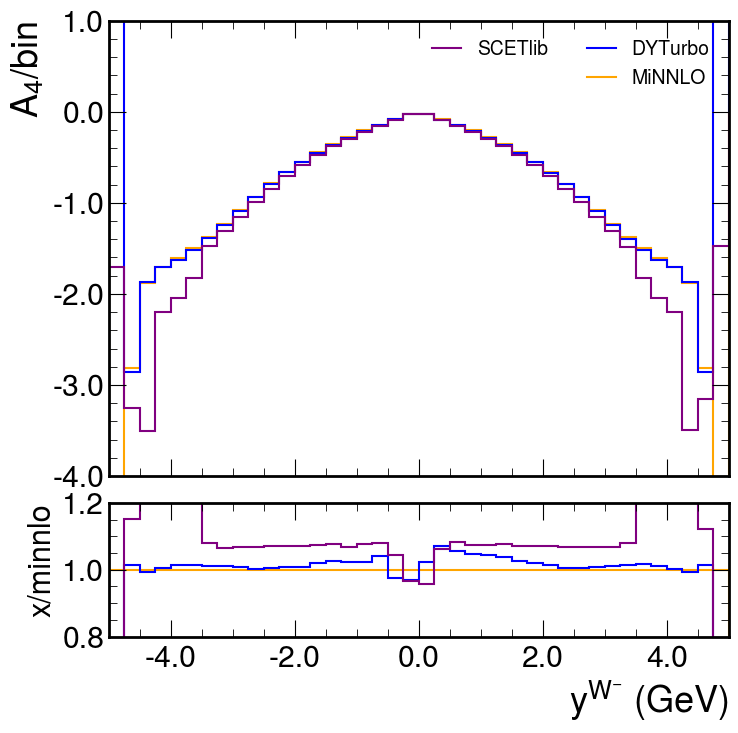

In [776]:
s = hist.tag.Slicer()
minnlo_coeffs_y_lowpt = theory_tools.moments_to_angular_coeffs(minnloh[{"ptVgen" : s[0:40.j:hist.sum]}].project("y", "helicity"))

fig = plot_tools.makePlotWithRatioToRef(
            [minnlo_coeffs_y[{"helicity" : 4.j}], -1*dyturbo_a4_y, scetlib_a4_y], 
            ["MiNNLO", 'DYTurbo', "SCETlib"], 
            colors=['orange', 'blue', "purple"], 
            xlabel="y$^{W^{-}}$ (GeV)", 
            ylabel="A$_{4}$/bin",
            rlabel="x/minnlo",
            rrange=[0.8, 1.2],
            ylim=[-4,1],
            xlim=None, binwnorm=None, baseline=True)

out = "/home/k/kelong/www/WMassAnalysis/TheoryComparisons/W/AngularCoeffs"
name = f"A4_y_MiNNLO_DYTurbo_SCETlib"
plot_tools.save_pdf_and_png(out, name)
plot_tools.write_index_and_log(out, name)

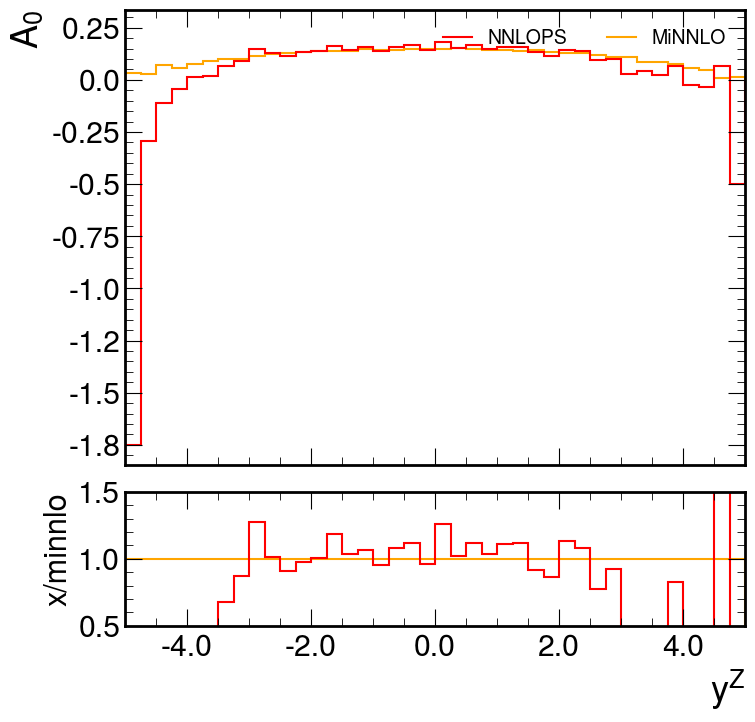

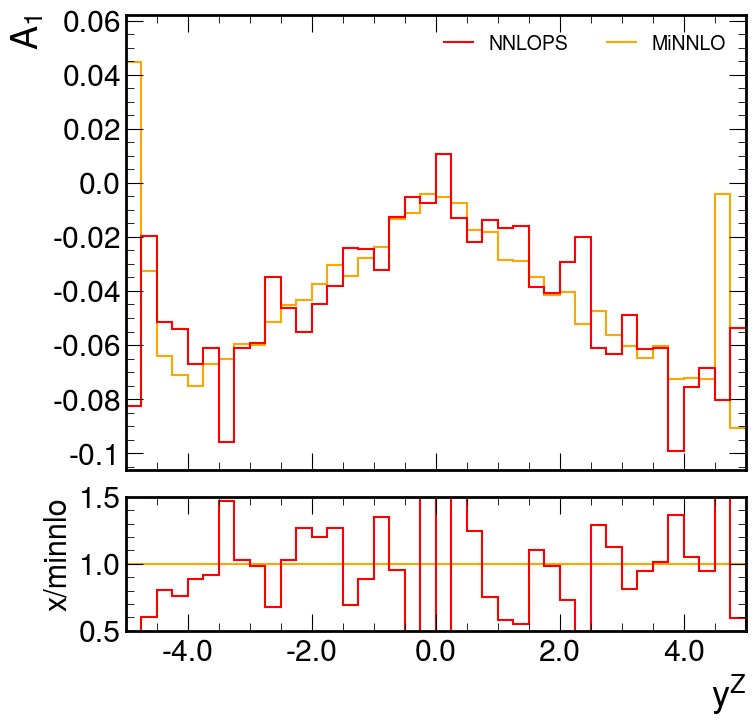

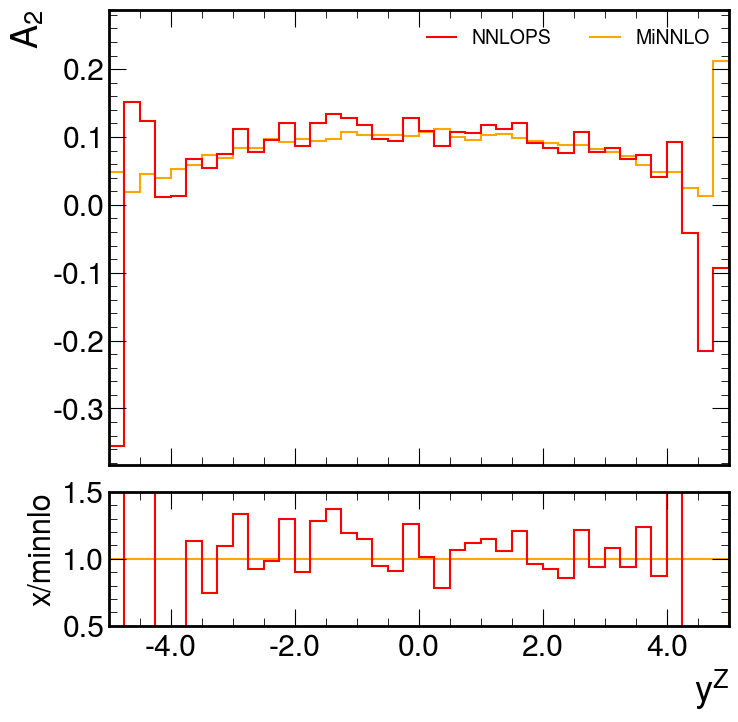

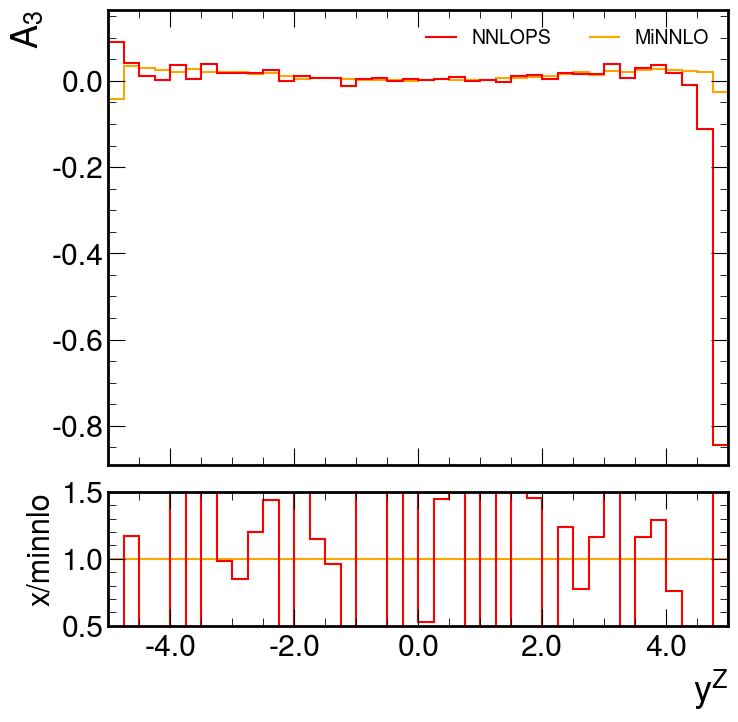

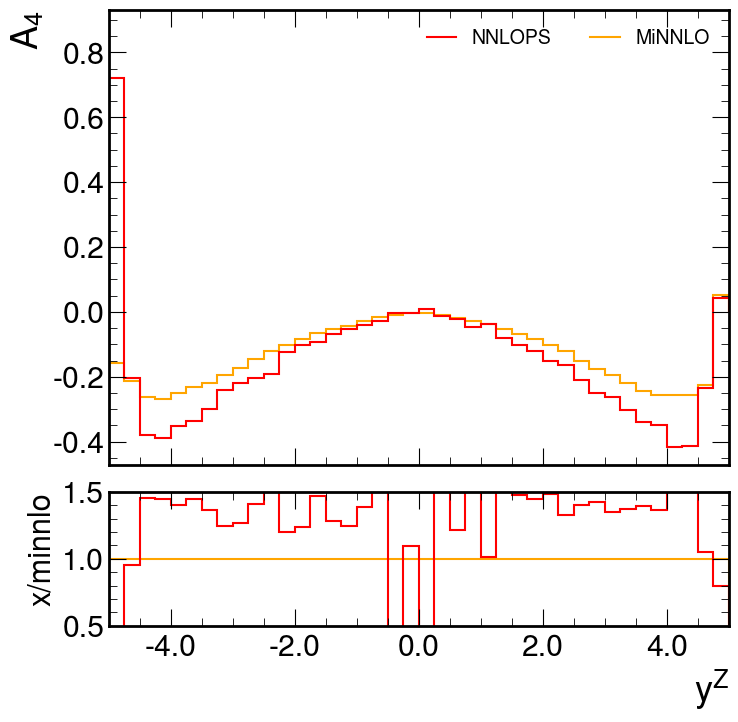

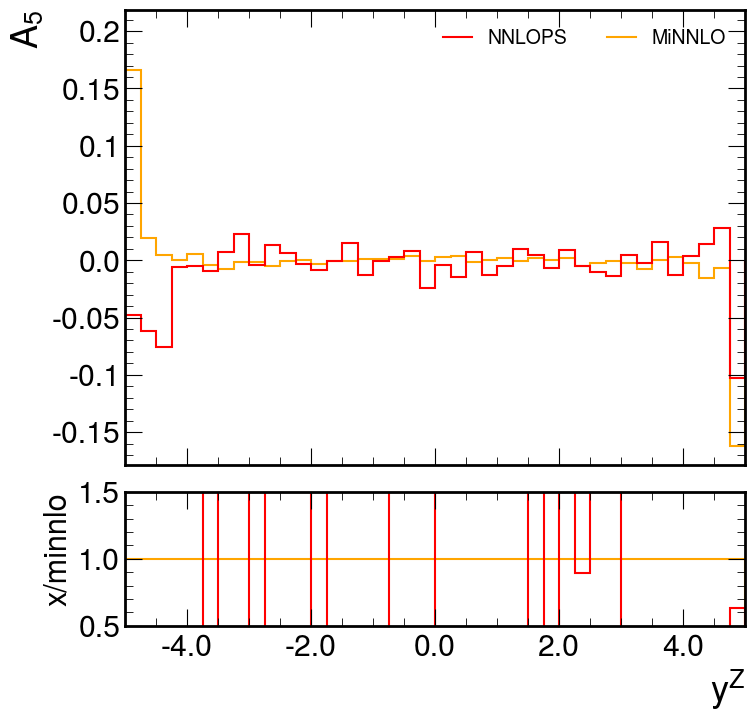

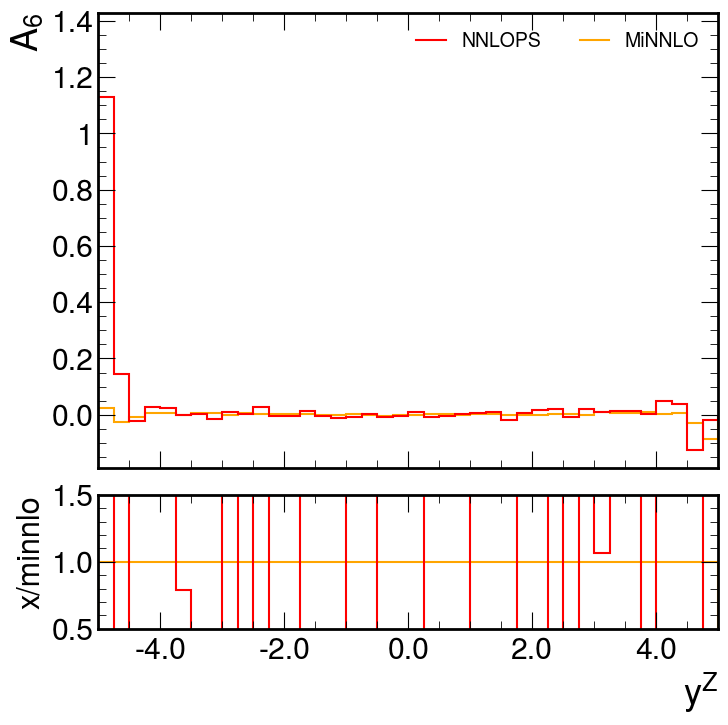

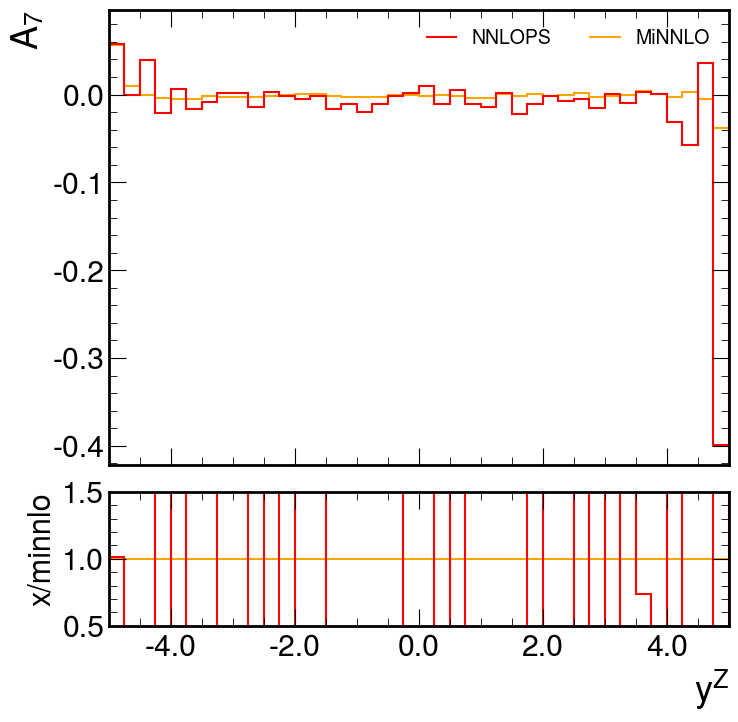

In [749]:
plotAllCoeffs("y", minnloZh[{"massVgen" : 90.j}], nnlopsZh[{"massVgen" : 90.j}], 5, "y$^{Z}$", out="/home/k/kelong/www/WMassAnalysis/TheoryComparisons/Z/AngularCoeffs")

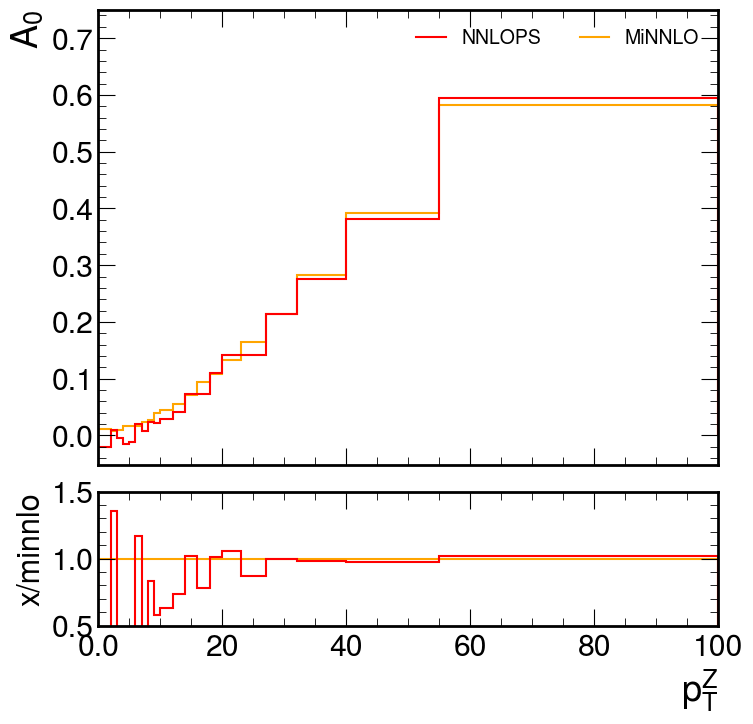

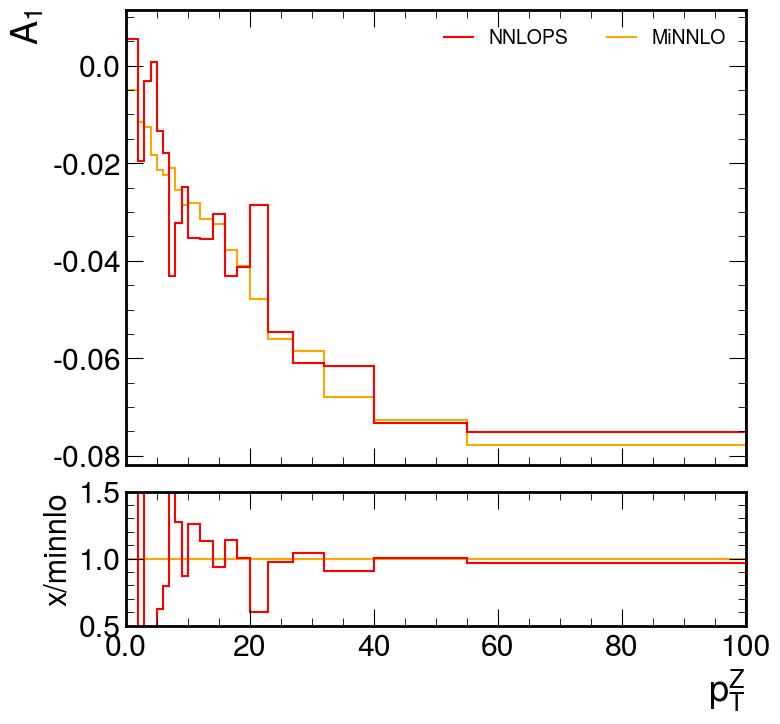

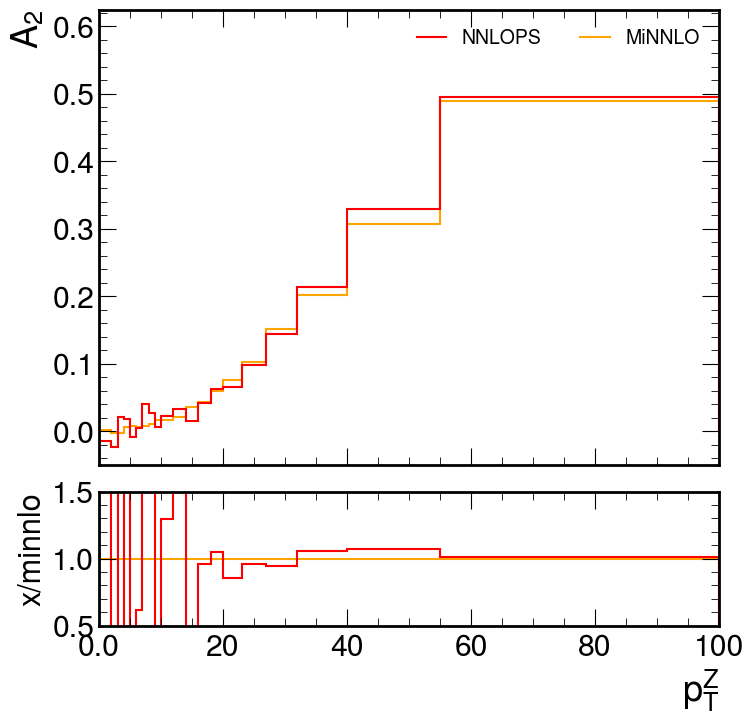

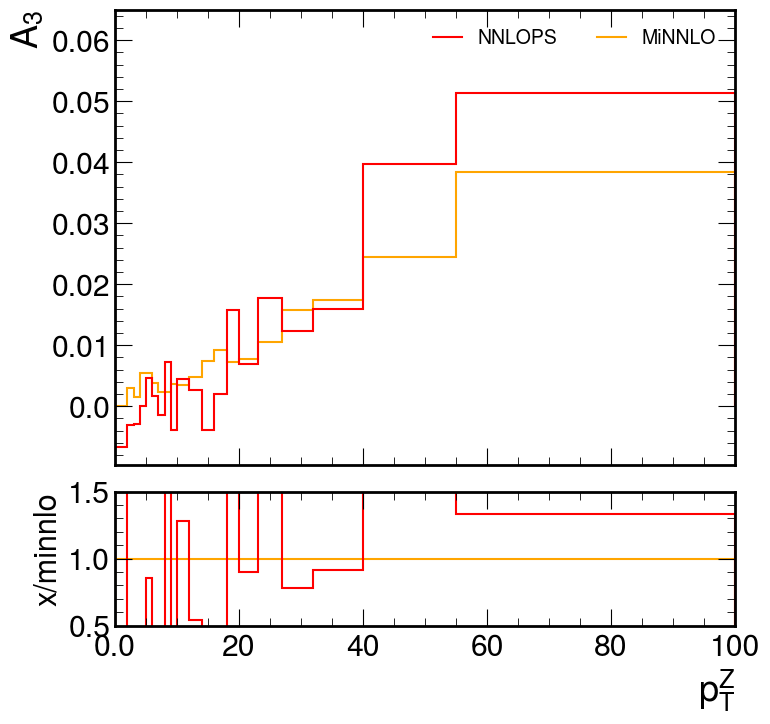

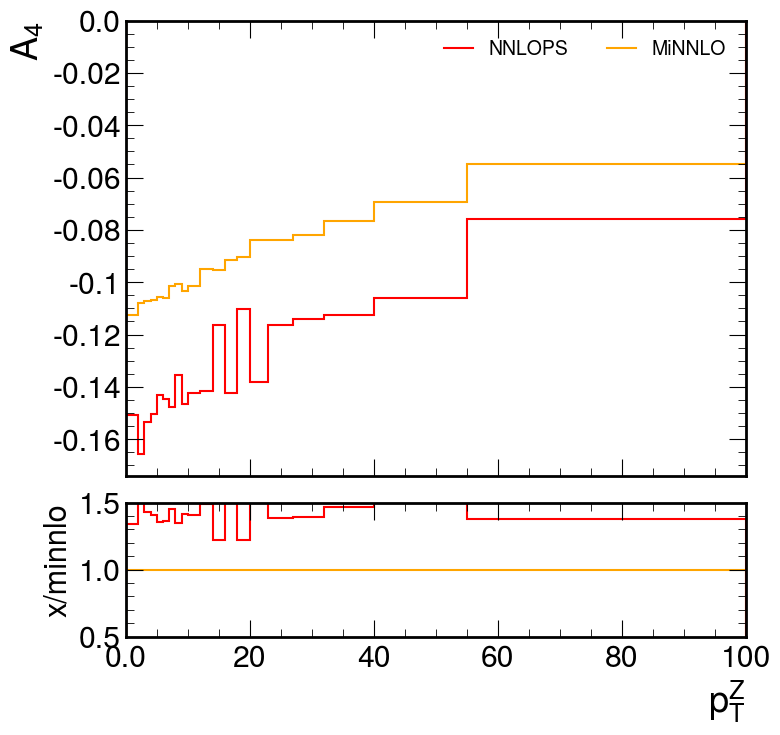

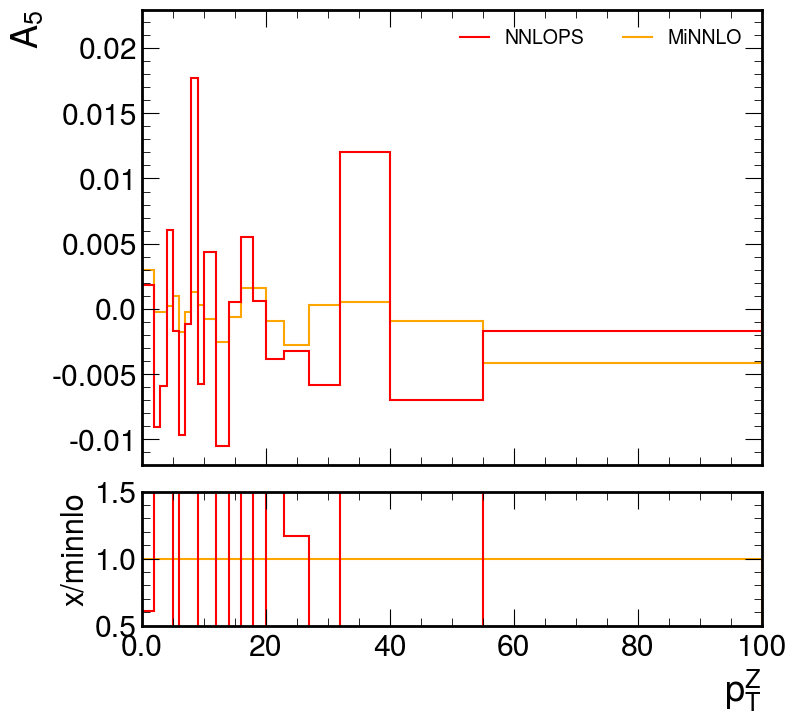

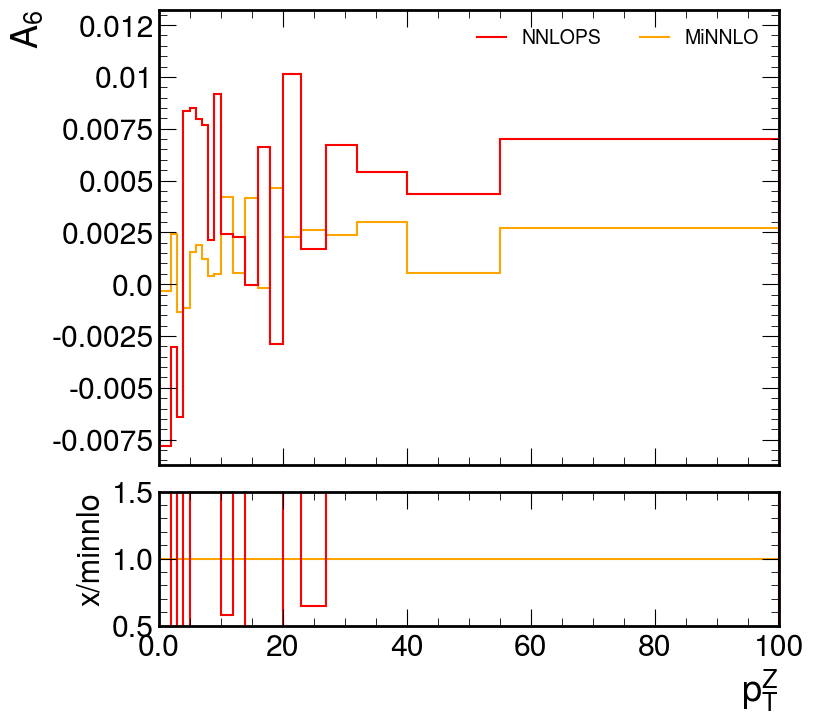

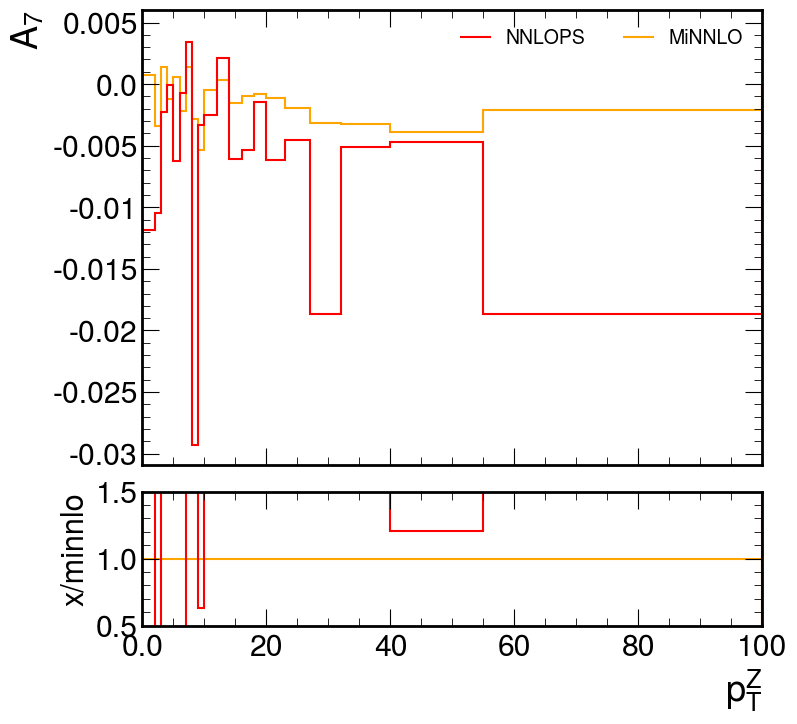

In [747]:
plotAllCoeffs("ptVgen", minnloZh[{"massVgen" : 90.j}], nnlopsZh[{"massVgen" : 90.j}], rebin, "p$_{T}^{Z}$", out="/home/k/kelong/www/WMassAnalysis/TheoryComparisons/Z/AngularCoeffs")


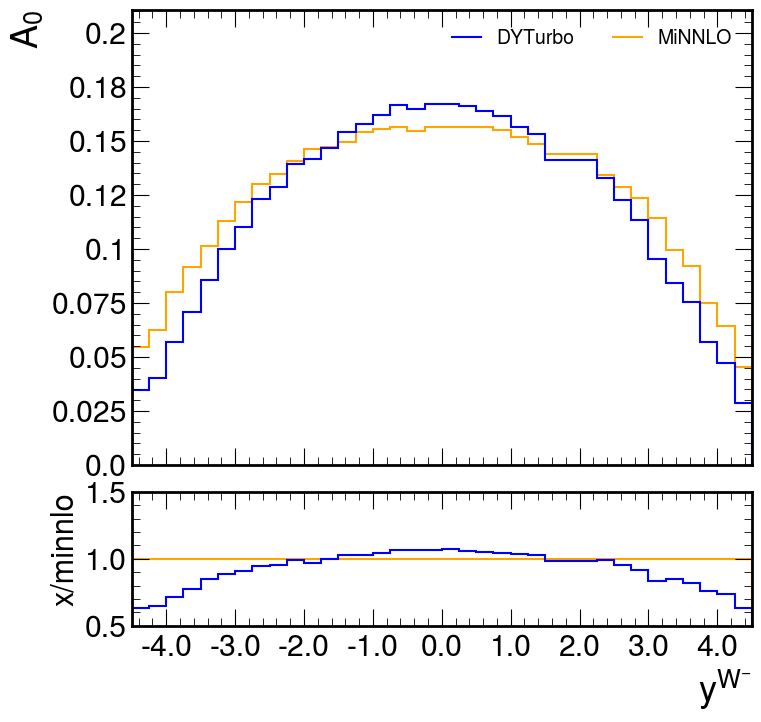

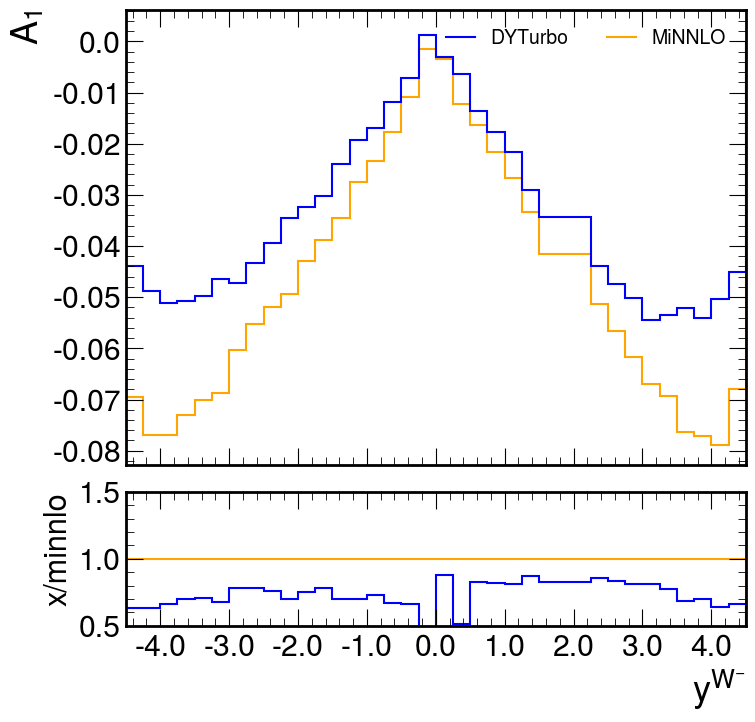

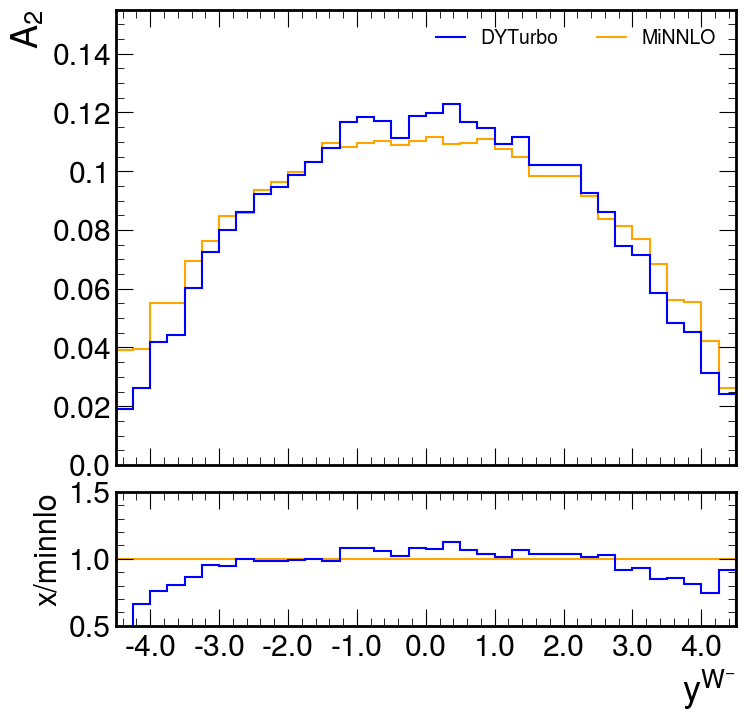

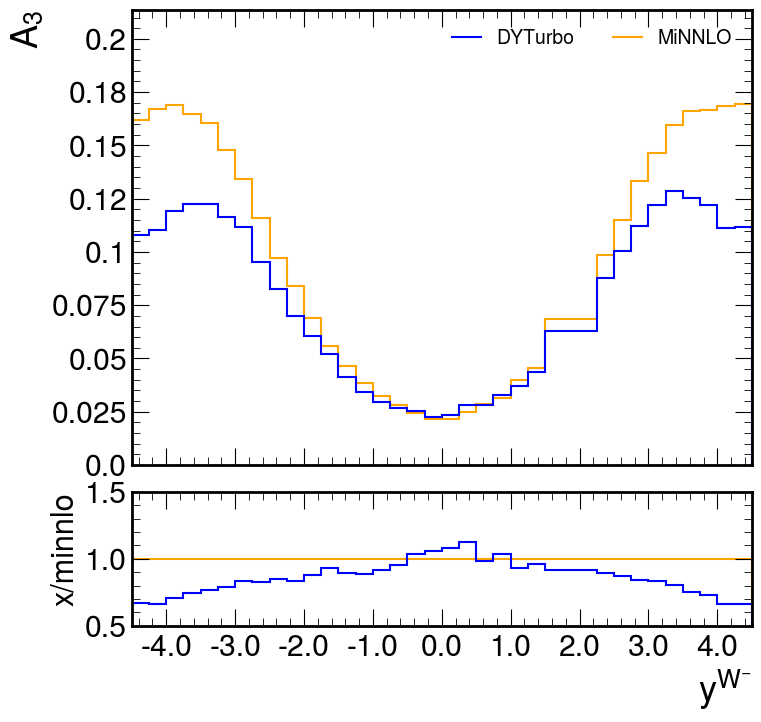

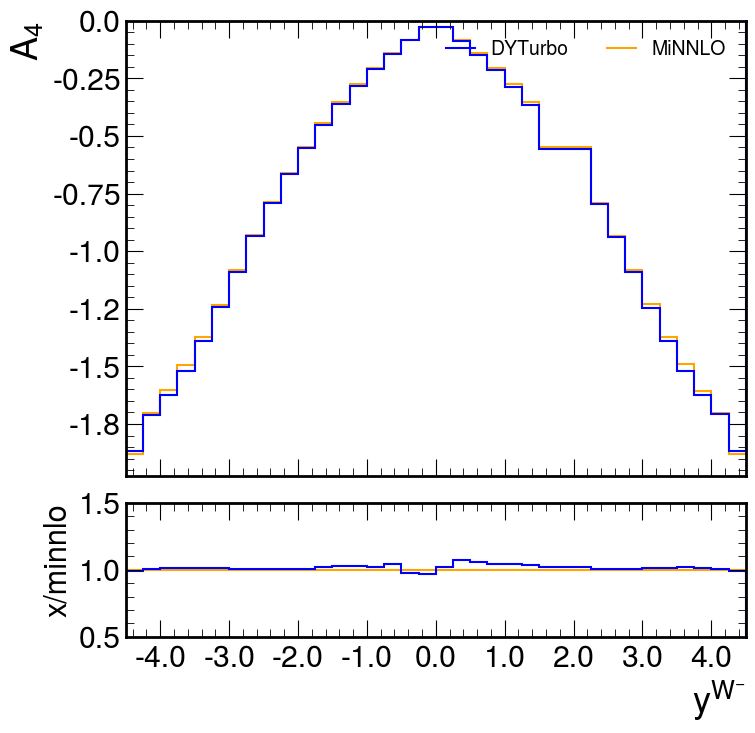

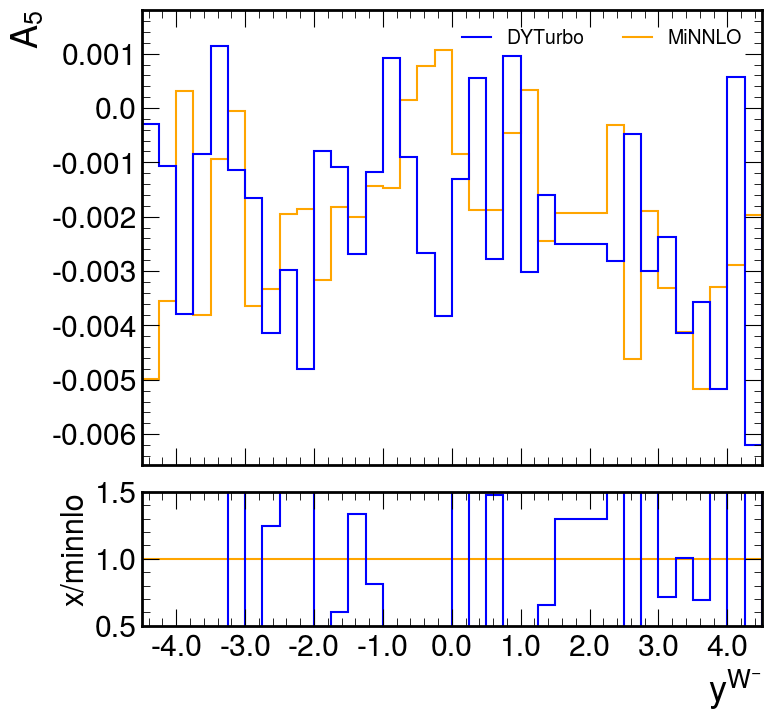

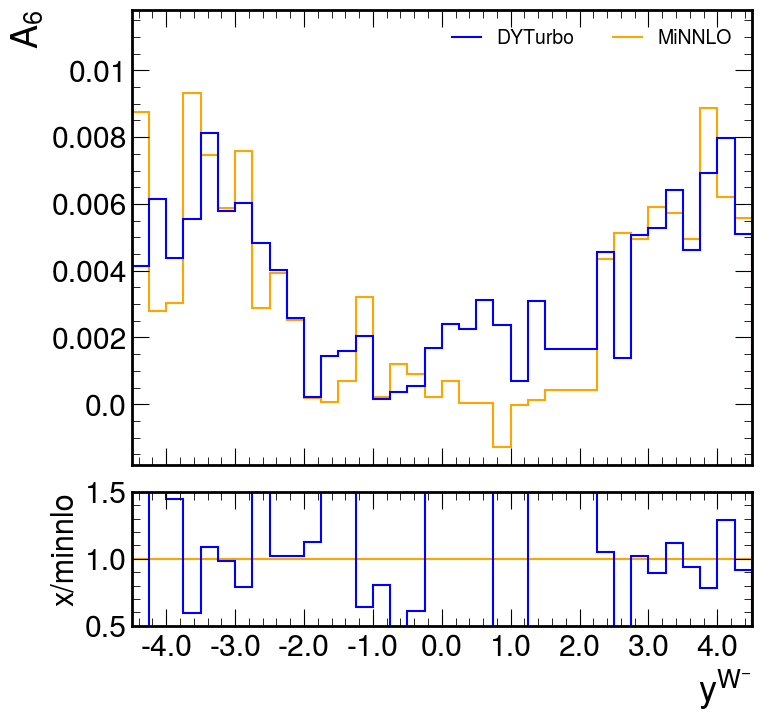

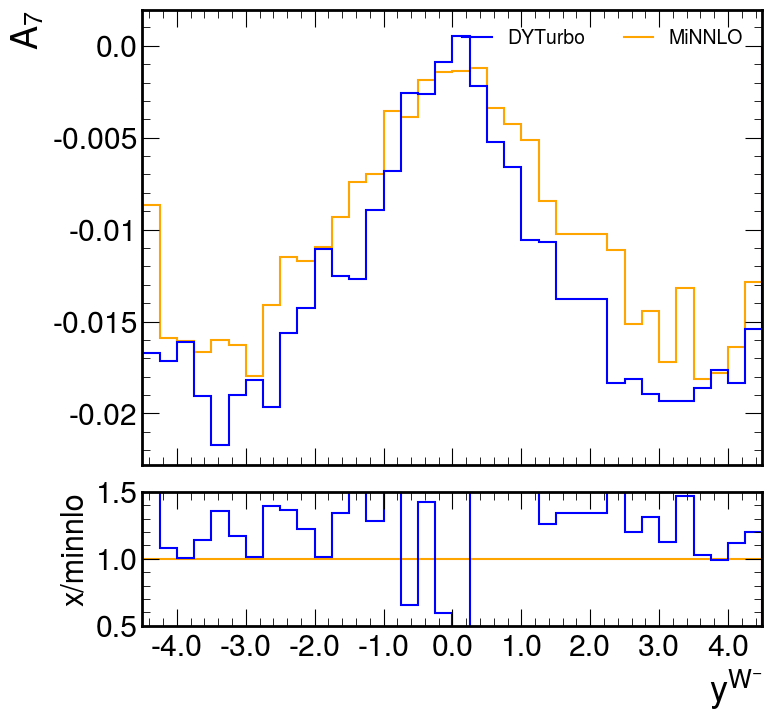

In [802]:
binning = hh.findCommonBinning([dyturbof_y["wgt_a0_y"].to_hist(), minnloWh.project("y")], 0)[2:-2]
plotAllCoeffsDYTurbo("y", minnloWh, dyturbof_y, binning, "y$^{W^{-}}$", out="/home/k/kelong/www/WMassAnalysis/TheoryComparisons/W/AngularCoeffs")

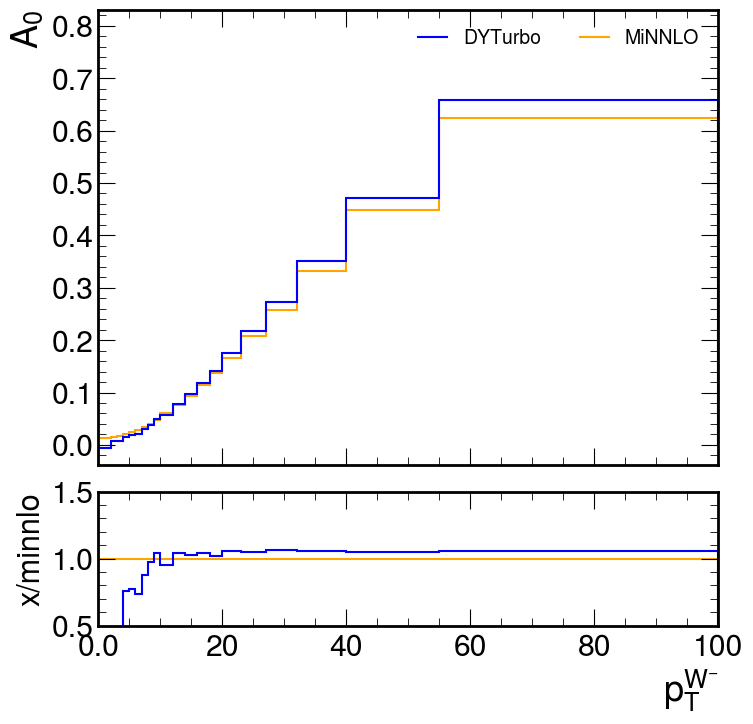

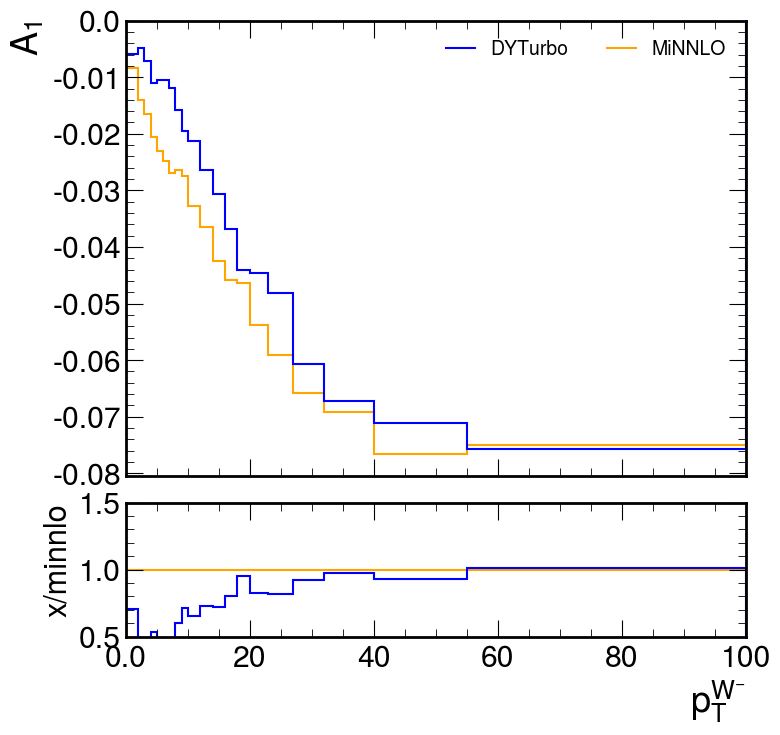

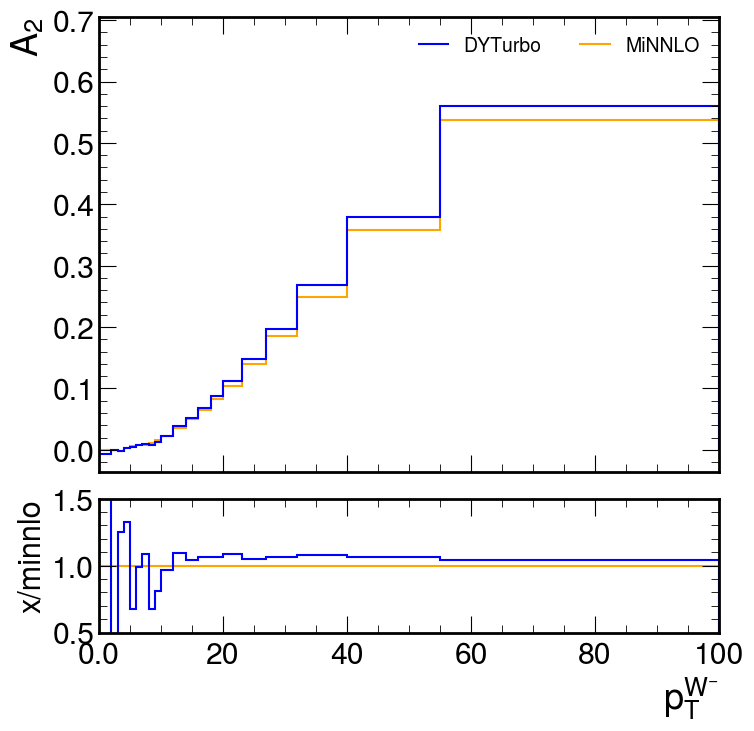

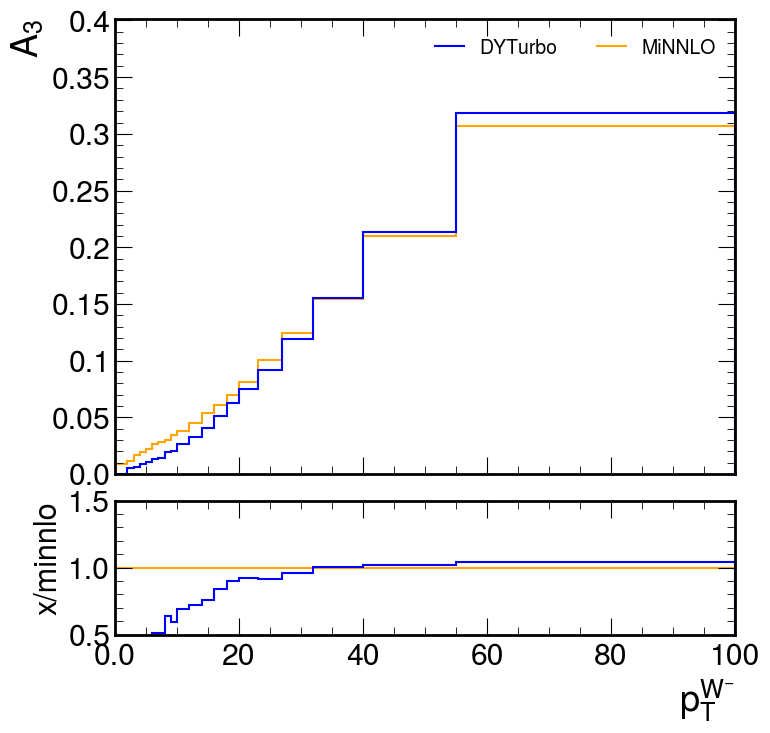

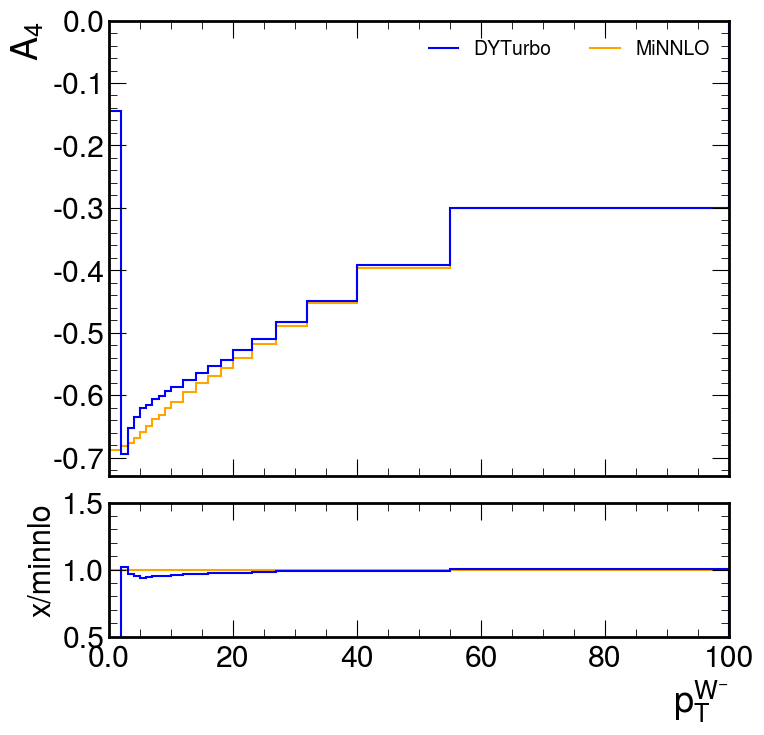

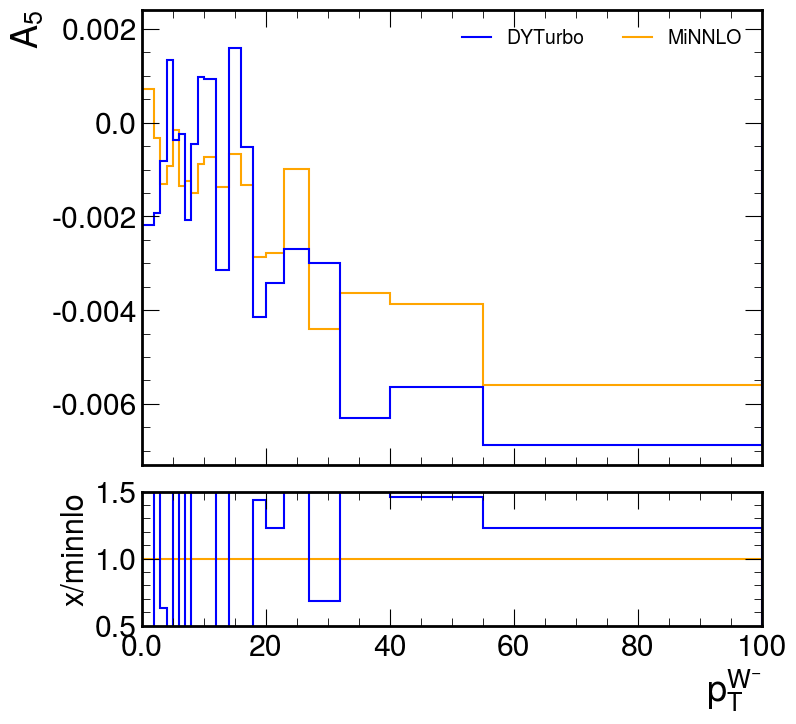

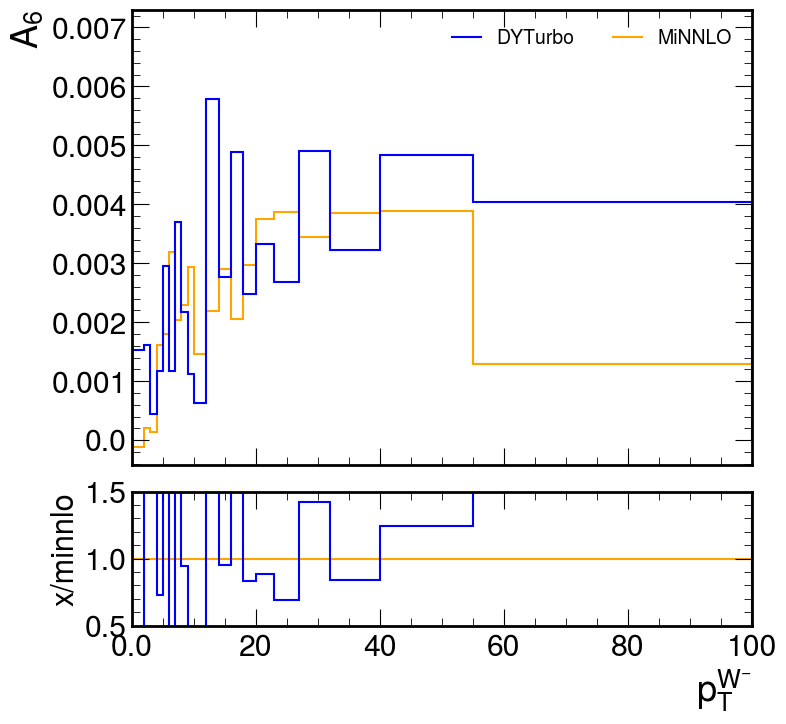

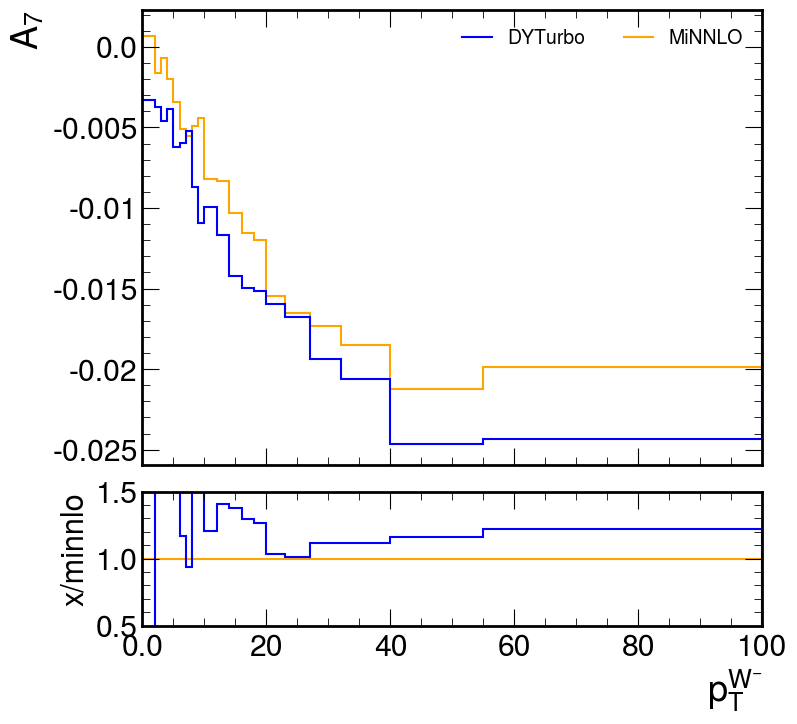

In [752]:
plotAllCoeffsDYTurbo("ptVgen", minnloWh, dyturbof_pt, pt_binning, "p$_{T}^{W^{-}}$", out="/home/k/kelong/www/WMassAnalysis/TheoryComparisons/W/AngularCoeffs")

In [1202]:
minlo = input_tools.load_and_scale(res, "ZmumuMiNLO", "nominal_gen")
nnlops = input_tools.load_and_scale(res, "ZmumuNNLOPS", "nominal_gen")
minnlo = input_tools.load_and_scale(res, "ZmumuPostVFP", "nominal_gen")
matrix = input_tools.read_matrixRadish_hist("/home/k/kelong/work/Generators/TheoryCorrections/MATRIX_RadISH/Zinclusive/run_matchMiNNLOEWParams/results/yZ__NNLO_QCD.dat", "y")

In [1205]:
minlo,nnlops,minnlo,matrix = hh.rebinHistsToCommon([minlo,nnlops,minnlo,matrix], "y")

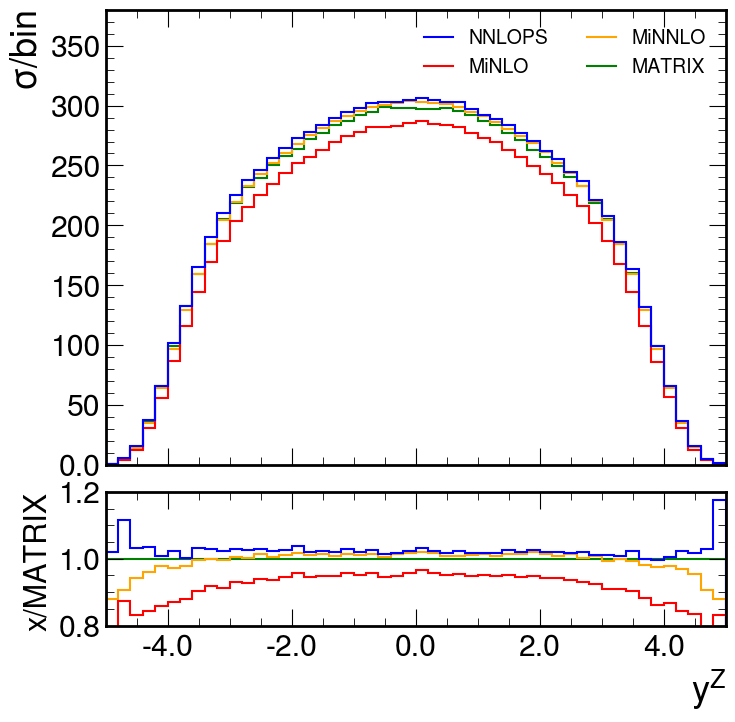

In [1206]:
fig = plot_tools.makePlotWithRatioToRef(
            [x.project("y")[hist.rebin(2)] for x in 
                 [matrix[{"vars" : 0}], minnlo, minlo, nnlops]
            ],
            ["MATRIX", "MiNNLO", "MiNLO", 'NNLOPS',], 
            colors=["green", "orange", 'red', 'blue',], 
            xlabel="y$^{Z}$", 
            ylabel=f"$\sigma$/bin",
            rlabel="x/MATRIX",
            rrange=[0.8, 1.2],
            ylim=[0,380],
            xlim=None, binwnorm=1.0, baseline=True)
out = "/home/k/kelong/www/WMassAnalysis/TheoryComparisons/Z"
plot_tools.make_plot_dir(out, "NNPDF31")
out = os.path.join(out, "NNPDF31")
plot_tools.save_pdf_and_png(out, "y_NNLOPS_MiNNLO")
plot_tools.write_index_and_log(out, "y_NNLOPS_MiNNLO")

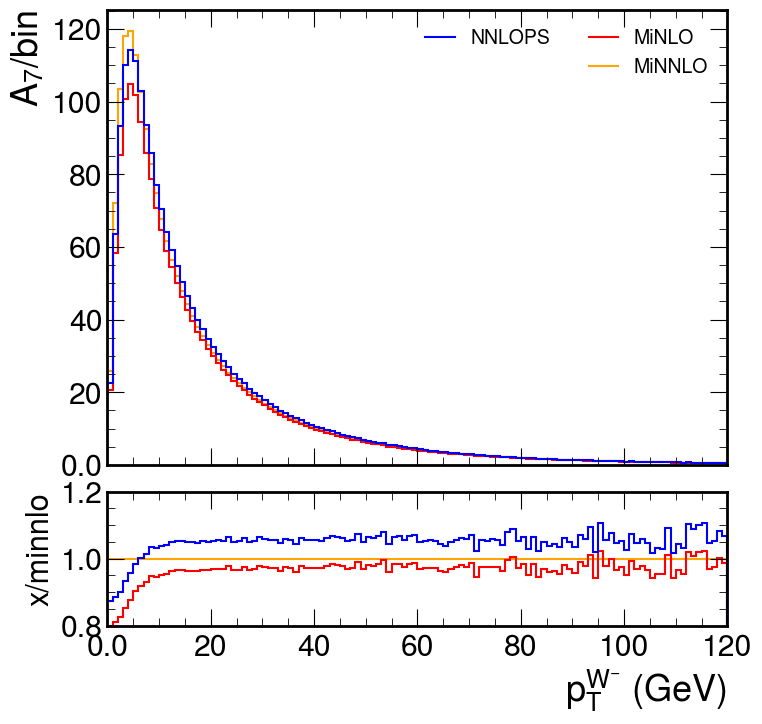

In [736]:
    fig = plot_tools.makePlotWithRatioToRef(
            [minnlo.project("ptVgen")[0:120.j],
             minlo.project("ptVgen")[0:120.j], 
             nnlops.project("ptVgen")[0:120.j]], 
            ["MiNNLO", "MiNLO", 'NNLOPS',], 
            colors=['orange', 'red', 'blue',], 
            xlabel="p$_{T}^{W^{-}}$ (GeV)", 
            ylabel=f"A$_{i}$/bin",
            rlabel="x/minnlo",
            rrange=[0.8, 1.2],
            #ylim=[-0.8,-0.3],
            xlim=None, binwnorm=1.0, baseline=True)
    
out = "/home/k/kelong/www/WMassAnalysis/TheoryComparisons/Z"
plot_tools.make_plot_dir(out, "NNPDF31")
out = os.path.join(out, "NNPDF31")
plot_tools.save_pdf_and_png(out, "ptVgen_NNLOPS_MiNNLO")
plot_tools.write_index_and_log(out, "ptVgen_NNLOPS_MiNNLO")

In [1208]:
with lz4.frame.open("../w_z_gen_dists_msht20.pkl.lz4") as f:
    res_msht = pickle.load(f)

In [841]:
minnloWh_msht = input_tools.load_and_scale(res_msht, "WminusmunuPostVFP", "helicity_moments_scale")[{"muRfact" : 1.j, "muFfact" : 1.j}].project("ptVgen", "y", "massVgen", "helicity")



In [1209]:
minnloWh_nnpdf = input_tools.load_and_scale(res, "WminusmunuPostVFP", "nominal_gen")
matrixWm_y = input_tools.read_matrixRadish_hist("/home/k/kelong/work/Generators/TheoryCorrections/MATRIX_RadISH/Winclusive/yW__NNLO_QCD.dat", "y")
dyturboWm_y = input_tools.read_dyturbo_file("/home/k/kelong/results_wminus_nnlo_yw.txt", "y")

In [1032]:
binning = hh.findCommonBinning([minnloWh_nnpdf.project("y")[hist.rebin(5)], matrixWm_y[{"vars" : 0}], dyturboWm_y], 0)

In [1210]:
minnloWm_y, matrixWm_y, dyturboWm_y = hh.rebinHistsToCommon([minnloWh_nnpdf.project("y"), matrixWm_y[{"vars" : 0}], dyturboWm_y], 0)

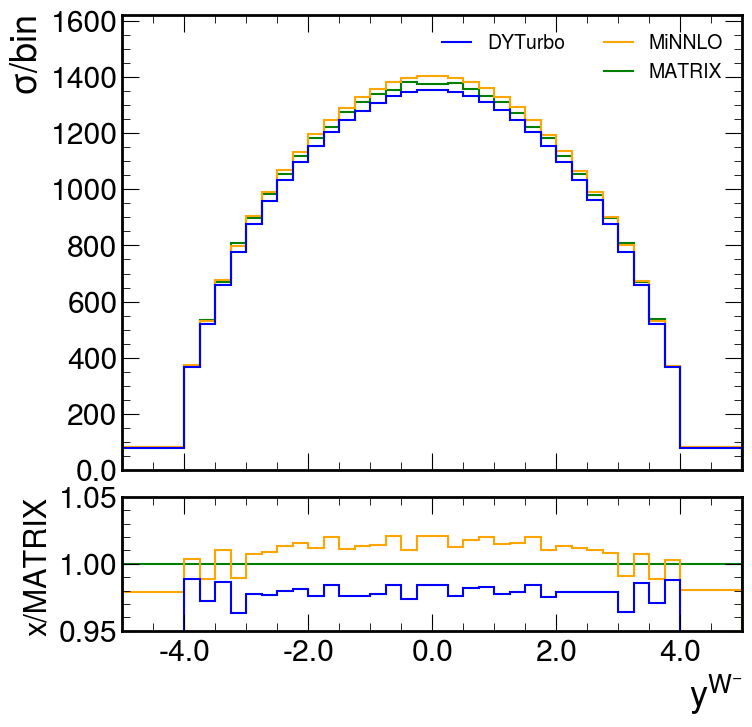

In [1218]:
    fig = plot_tools.makePlotWithRatioToRef(
            [matrixWm_y, minnloWm_y, dyturboWm_y],
            ["MATRIX", "MiNNLO", "DYTurbo"], 
            colors=['green', 'orange', 'blue'], 
            xlabel="y$^{W^{-}}$", 
            ylabel="$\sigma$/bin",
            rlabel="x/MATRIX",
            rrange=[0.95, 1.05],
            yscale=1.1,
            xlim=None, binwnorm=1.0, baseline=True)

In [1264]:
def dyturbo_filenames(path, basename, varname, pieces=["n3ll_born", "n2ll_ct", "n2lo_vj"], append=None):
    return [os.path.join(path, "_".join(filter(None, [basename, piece, varname, append]))+".txt") for piece in pieces]

In [1430]:
def read_dyturbo_variations(path, basename, varnames, axes, pieces=["n3ll_born", "n2ll_ct", "n2lo_vj"], append=None):
    central_files = dyturbo_filenames(path, basename, "", pieces, append)
    centralh = input_tools.read_dyturbo_hist(central_files, axes=axes)
    var_ax = hist.axis.Integer(0, len(varnames)+1, name="vars")
    varh = hist.Hist(*centralh.axes, var_ax, storage=centralh._storage_type())
    varh[...,0] = centralh.view(flow=True)
    for i,var in enumerate(varnames):
        filenames = [os.path.join(path, "_".join(filter(None, [basename, piece, var, append]))+".txt") for piece in pieces]
        varh[...,i+1] = input_tools.read_dyturbo_hist(filenames, axes=axes).view(flow=True)
    return varh       

In [1441]:
varnames = input_tools.dyturbo_varnames()

In [1442]:
varh = input_tools.read_dyturbo_variations("/scratch/shared/TheoryPredictions/DYTurbo/Z/nnpdf31", "results", varnames, axes=["pt",])

Count is 13


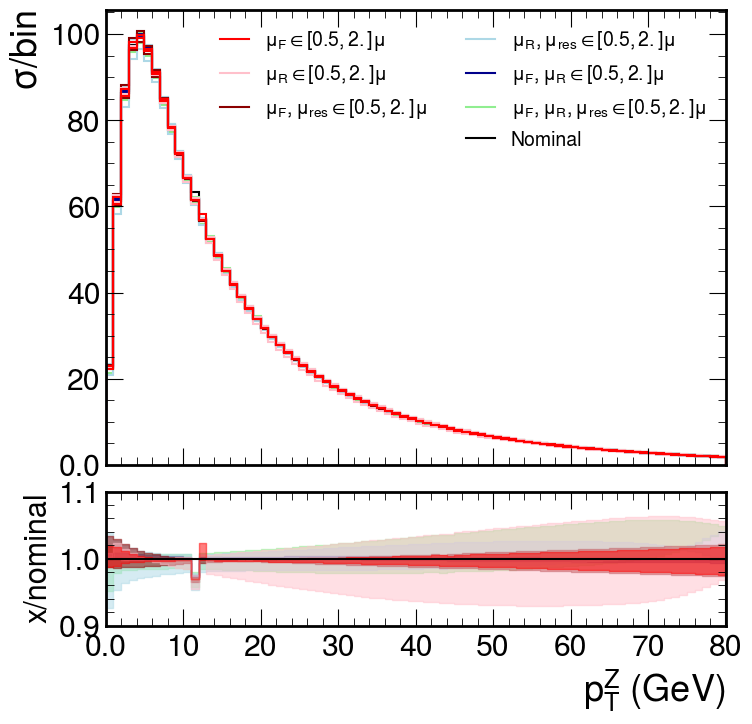

In [1444]:
hists = [varh[{"vars" : 0}], *itertools.chain(*[(varh[{"vars" : i}], varh[{"vars" : 15-i}]) for i in range(1, 8)])]
fig = plot_tools.makePlotWithRatioToRef(hists[:-2],
            ["Nominal", 
             "$\mu_{F}, \mu_{R}, \mu_{res} \in [0.5, 2.]\mu$", "", 
             "$\mu_{F}, \mu_{R} \in [0.5, 2.]\mu$", "",
             "$\mu_{R}, \mu_{res} \in [0.5, 2.]\mu$", "", 
             "$\mu_{F}, \mu_{res} \in [0.5, 2.]\mu$", "", 
             "$\mu_{R} \in [0.5, 2.]\mu$", "", 
             "$\mu_{F} \in [0.5, 2.]\mu$", "",
            ],#"$\mu_{res} \in [0.5, 2.]\mu$", "",],
            colors=['black', 'lightgreen', 'lightgreen', "darkblue", "darkblue", "lightblue", "lightblue", "darkred", "darkred",
                   "pink", "pink", "red", "red", "grey", "grey"][:-2], 
            xlabel="p$_{T}^{Z}$ (GeV)", 
            ylabel="$\sigma$/bin",
            rlabel="x/nominal",
            rrange=[0.9, 1.1],
            xlim=None, binwnorm=1.0, baseline=True, fill_between=True)

In [1445]:
scetlibh = input_tools.read_scetlib_hist("/home/k/kelong/work/Generators/TheoryCorrections/SCETlib/Z/inclusive_Z_MSHT20.pkl")
#scetlibh = input_tools.read_scetlib_hist("/home/k/kelong/work/Generators/TheoryCorrections/SCETlib/Z/inclusive_Z.pkl")

In [1446]:
t = syst_tools.syst_transform_map("nominal_gen", "pt")
scetlib_pt = scetlibh.project("pt", "vars")

Count is 9


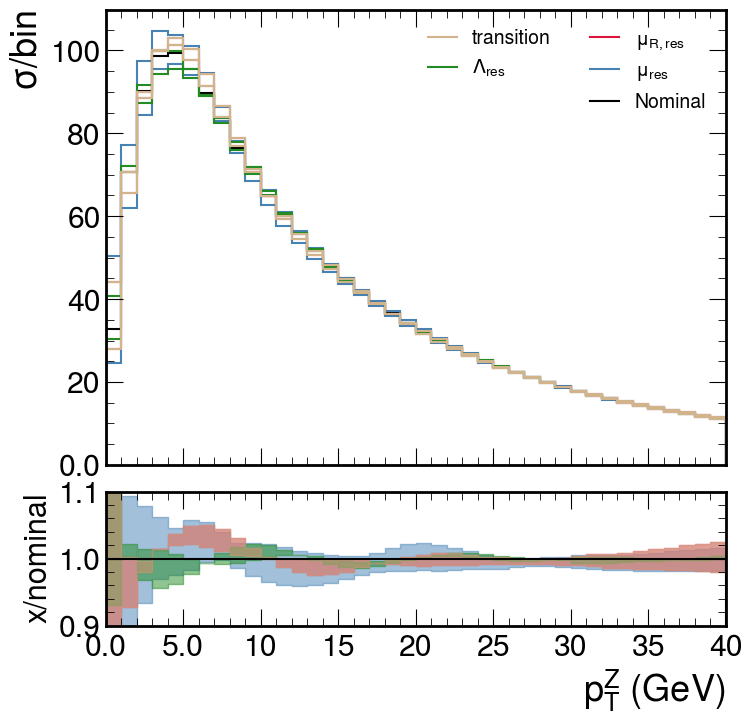

In [1447]:
fig = plot_tools.makePlotWithRatioToRef(
            [scetlib_pt[{"vars" : 0}], 
                t["resumScaleMax"]["action"](scetlib_pt), t["resumScaleMin"]["action"](scetlib_pt),
                t["resumFOScaleUp"]["action"](scetlib_pt), t["resumFOScaleDown"]["action"](scetlib_pt),
                t["resumLambdaUp"]["action"](scetlib_pt), t["resumLambdaDown"]["action"](scetlib_pt),
                t["resumFOScaleUp"]["action"](scetlib_pt), t["resumFOScaleDown"]["action"](scetlib_pt),
            ],
            ["Nominal", 
             "$\mu_{res}$", "", 
             "$\mu_{R,res}$", "",
             "$\Lambda_{res}$", "",
             "transition", "",
            ],
            colors=['black', 'steelblue', 'steelblue', 'crimson', 'crimson', 'forestgreen', 'forestgreen', 'tan', 'tan'], 
            xlabel="p$_{T}^{Z}$ (GeV)", 
            ylabel="$\sigma$/bin",
            rlabel="x/nominal",
            rrange=[0.9, 1.1],
            xlim=None, binwnorm=1.0, baseline=True, fill_between=True)

In [230]:
scaledW = theory_tools.scale_angular_moments(minnloWh)

In [245]:
minnloW_rebin = hh.rebinHist(hh.makeAbsHist(minnloWh, "y"), "ptVgen", common.ptV_binning)[{"absy" : hist.rebin(8)}]

In [246]:
unrolledWms = [sel.unrolledHist(minnloW_rebin[{"helicity" : i}], ("ptVgen", "absy", )) for i in range(9)]

Count is 9


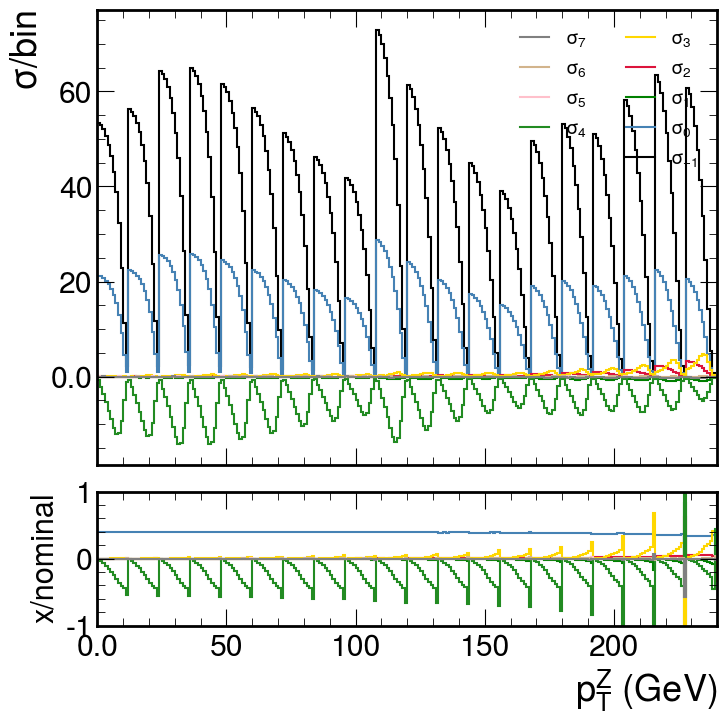

In [249]:
fig = plot_tools.makePlotWithRatioToRef(
            unrolledWms,
            [f"$\sigma_{{{i-1}}}$" for i in range(9)],
            colors=['black', 'steelblue', 'green', 'crimson', 'gold', 'forestgreen', 'pink', 'tan', 'grey'], 
            xlabel="p$_{T}^{Z}$ (GeV)", 
            ylabel="$\sigma$/bin",
            rlabel="x/nominal",
            rrange=[-1, 1],
            xlim=None, binwnorm=1.0, baseline=True, fill_between=False)

In [254]:
with lz4.frame.open("../mz_wlike_with_mu_eta_pt_nnpdf31_lbl.pkl.lz4") as f:
    resZ = pickle.load(f)

In [272]:
ls -ltrh ../CombineResults/pdfNNPDF31/ZMassWLike/ZMassWLikeCombineInput.root

-rw-r--r-- 1 kelong zh 40K Jan 11 17:56 ../CombineResults/pdfNNPDF31/ZMassWLike/ZMassWLikeCombineInput.root


In [270]:
f = uproot.open("../CombineResults/pdfNNPDF31/ZMassWLike/ZMassWLikeCombineInput.root")

In [263]:
f["x_Zmumu_massShift100MeVDown_plus"].to_hist()

Hist(Regular(60, 60, 120, name='xaxis'), storage=Weight()) # Sum: WeightedSum(value=3.98107e+06, variance=1.90512e+06)

Count is 3


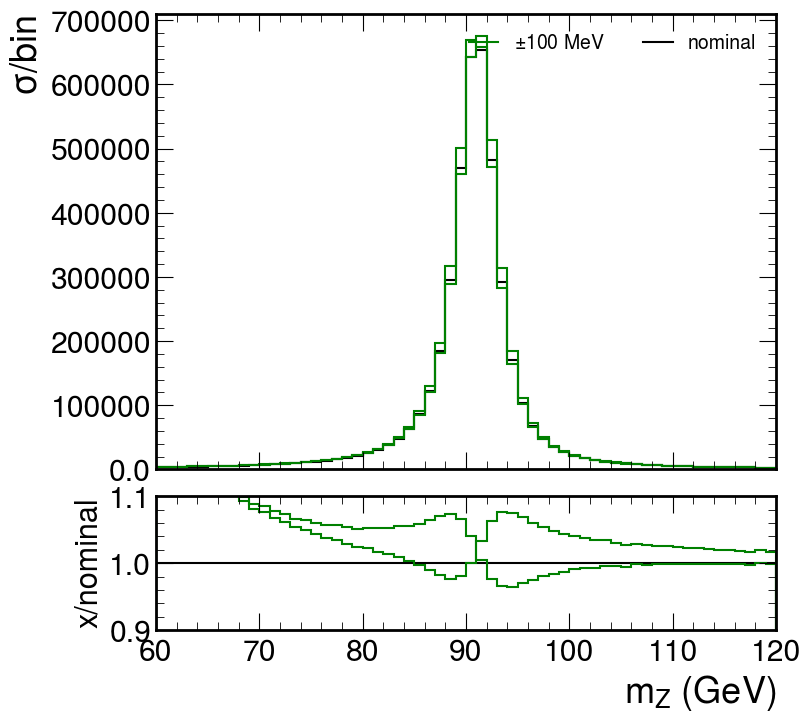

In [274]:
fig = plot_tools.makePlotWithRatioToRef(
            [f["x_Zmumu_minus"].to_hist(),
                 f["x_Zmumu_massShift100MeVDown_minus"].to_hist(),
                 f["x_Zmumu_massShift100MeVUp_minus"].to_hist(),
            ],
            ["nominal", "$\pm 100$ MeV", ""],
            colors=['black', 'green', 'green'], 
            xlabel="m$_{Z}$ (GeV)", 
            ylabel="$\sigma$/bin",
            rlabel="x/nominal",
            rrange=[0.9, 1.1],
            xlim=None, binwnorm=1.0, baseline=True, fill_between=False)